In [1]:
import os
import torch
from collections import Counter, OrderedDict
from operator import itemgetter
import random
from random import sample
import numpy as np
import json
from collections import OrderedDict
import pickle
import matplotlib.pylab as plt
from functools import partial
import pprint
import hashlib
import copy
import sys
import math
from copy import deepcopy
import hashlib
import uuid 
import ast
# Baby-ARC related imports
from constants import *
from utils import *
from objects import *
from operator import *
from canvas import *
from dataset import *
from itertools import product
import re
# random seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# global vars
RUN_AS_CREATOR = False
ARC_OBJ_LOADED = False
DEMO_MAX_ARC_OBJS = 500
pp = pprint.PrettyPrinter(indent=4)

import logging
FORMAT = "%(asctime)-15s %(message)s"
logging.basicConfig(format=FORMAT, level=logging.DEBUG,
                    datefmt="%Y-%m-%d %H:%M")
logger = logging.getLogger(__name__)

if RUN_AS_CREATOR:
    logger.info("WARNING: You are using this a creator of BabyARC, it assumes you install all dependencies!")
    logger.info("If you are not the creator, please disable this. All functionalities of recreating the dataset is still here!")
tmp_data_dirname = "../../../../concept_env/datasets" # Using your own directory!

### Collect Objects from the ARC dataset
**WARNING:** This will fail, please use our pre-collected arc object files. We made this avaliable. The process of making this file involves hidden logics which will not be revealed. Currently, you can treat it as just a set of generated object pool!

Details about the ARC can be found: https://github.com/fchollet/ARC. Note that you only have to run this one time, it will generate a file and save to the output directory. Later, you can simply use it! 

In [2]:
if RUN_AS_CREATOR:
    training_objs = []
    for filename in os.listdir(arc_data_train_path):
        if filename.endswith(".json"):
            print("extracting objs from task: ", filename)
            training_objs.extend(single_task_obj_parser(filename.split(".")[0]))
    # we only need to parse once, and save it to the disk
    torch.save(training_objs, os.path.join(tmp_data_dirname, 'arc_objs.pt'))
else:
    try:
        arc_objs = torch.load(os.path.join(tmp_data_dirname, 'arc_objs.pt'))
        logger.info("SUCCESS! You loaded the pre-collected object file from ARC!")
        ARC_OBJ_LOADED = True
    except:
        logger.info("Please check if obejct file in the directory indicated above!")
        logger.info(f"WARNING: Please get those pre-collected ARC objects in {os.path.join(tmp_data_dirname, 'arc_objs.pt')}!")
        logger.info("You can download this file from: https://drive.google.com/file/d/1dZhT1cUFGvivJbSTwnqjou2uilLXffGY/view?usp=sharing")

2021-03-28 00:43 SUCCESS! You loaded the pre-collected object file from ARC!


### Pre-checks before moving forward with the Demo!

These are some prechecks we enforced to ensure good user experience with this Demo! Please make sure you pass the test!

In [3]:
if not ARC_OBJ_LOADED or RUN_AS_CREATOR:
    logger.info("FAILED! Resolve issues before moving forward with this Demo file!")
else:
    logger.info("PASSED!")

2021-03-23 13:55 PASSED!


### Object Engine

In [4]:
ObE = ObjectEngine(arc_objs[:DEMO_MAX_ARC_OBJS])
# Below the log, it should shows how many objects it loads.
# Iso obj means the count of unique objects (considering rotations, color permutations, etc..)
_ = ObE.sample_objs_by_fixed_width()
# If no error, that means you successfully sampled an object!

2021-03-23 13:55 Original obj count = 500
2021-03-23 13:55 Iso obj count = 51


### Canvas Engine
You can now place different objects based on different relations if provided on the Canvas!

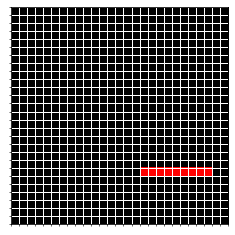

In [5]:
test_canvas = CanvasEngine().sameple_canvas()[0]
objs1 = ObE.sample_objs_with_line(n=1, len_lims=[5,10], thickness=1, rainbow_prob=0.1, direction="h")
# Here is just one example with how you can sample different objects from the object engine!
results = test_canvas.placement(objs1[0])
if results == -1:
    logger.info("Placement step failed! Please rerun!")
else:
    test_canvas.render(minimum_cover=False)

### BabyARC Canvas
This is the dataset class where you can sample canvas in a much higher level!

In [29]:
demo_dataset = \
    BabyARCDataset(pretrained_obj_cache=os.path.join(tmp_data_dirname, 'arc_objs.pt'),
                   save_directory="./BabyARCDataset/", 
                   object_limit=1, noise_level=0, canvas_size=20)

2021-03-28 00:24 Creating new BabyARC dataset by loading in pretrained objects.
2021-03-28 00:24 Loading the object engine and canvas engine with a limit of object number 1, background_color=0.
2021-03-28 00:24 Original obj count = 1
2021-03-28 00:24 Iso obj count = 1
2021-03-28 00:24 Create BabyARC canvas with fixed width and height = 10.


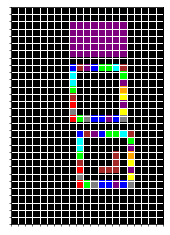

In [14]:
canvas_dict = demo_dataset.sample_single_canvas_by_core_edges(
    OrderedDict([(('obj_0', 'obj_1'), 'IsInside'), 
                 (('obj_2', 'obj_1'), 'SameAll'), 
                 (('obj_2', 'obj_3'), 'SameCol')]))

### Operators


In [36]:
demo_dataset = \
    BabyARCDataset(pretrained_obj_cache=os.path.join(tmp_data_dirname, 'arc_objs.pt'),
                   save_directory="./BabyARCDataset/", 
                   object_limit=1, noise_level=0, canvas_size=20)

repre_dict_1 = demo_dataset.sample_single_canvas_by_core_edges(
    OrderedDict([(('obj_0', 'line_[6,1,0]'), 'Attr'), 
                 (('obj_1', 'line_[7,1,1]'), 'Attr')]), 
    allow_connect=True, is_plot=False
)
in_canvas_1 = Canvas(
    repre_dict=repre_dict_1
)

repre_dict_2 = demo_dataset.sample_single_canvas_by_core_edges(
    OrderedDict([(('obj_0', 'line_[6,1,0]'), 'Attr'), 
                 (('obj_1', 'line_[7,1,1]'), 'Attr')]), 
    allow_connect=True, is_plot=False
)
in_canvas_2 = Canvas(
    repre_dict=repre_dict_2
)

if in_canvas_1 == -1 or in_canvas_2 == -1:
    print("CANVAS FAILED!")

out_canvas_list, _ = OperatorEngine().operate_rotate(
    [in_canvas_1, in_canvas_2], [["obj_0"], ["obj_1"]],
    operator_tag="#ROTATE_3", 
    allow_connect=True, allow_shape_break=False
)
if out_canvas_list == -1:
    print("OPERATOR FAILED!")

(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         

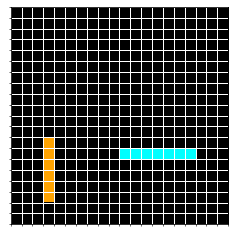

In [37]:
in_canvas_1.render()

(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         

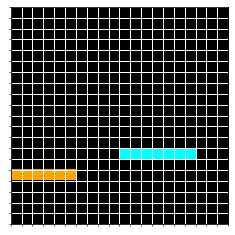

In [38]:
out_canvas_list[0].render()

In [29]:
out_canvas_list[0].repr_as_dict()

OrderedDict([('id_object_map',
              OrderedDict([(0, tensor([[5., 5., 5., 5., 5., 5.]])),
                           (1, tensor([[9., 9., 9., 9., 9., 9., 9.]]))])),
             ('id_position_map',
              OrderedDict([(0, tensor([ 5, -2])), (1, tensor([3, 2]))])),
             ('background_color', 0),
             ('node_id_map', OrderedDict([('obj_0', 0), ('obj_1', 1)])),
             ('partial_relation_edges',
              OrderedDict([(('obj_0', 'line_[6,1,0]'), 'Attr'),
                           (('obj_1', 'line_[7,1,1]'), 'Attr')])),
             ('image_t',
              tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 9., 9., 9., 9., 9., 9., 9., 0.],
                      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                      [5., 5., 5., 5., 0., 0., 0., 0., 5., 5.],
                      [0., 0

In [18]:
# load operators, and generate sample outputs!

### BabyARC in Actions: Generate Outputs

In [19]:
# generate a full example with BabyARC!